<center><h3 style="color:red;">Mulitclass sentiment analysis</h3></center>

<h5>Data Exploration and Cleaning</h5>

In [1]:
# Import necessary libraries
import pandas as pd
# import numpy as np
from sklearn.impute import SimpleImputer


# Load the dataset
file_path = './dataset/Dataset.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
data.head()

,Customer_ID,Name,Age,Annual_Income,Education_Level,Occupation,City,Customer_Reviews,Purchase_Frequency,Product_Category,Target_Variable
0,CUST0001,Customer_1,64.0,77964.61,Bachelor,Engineer,Phoenix,Amazing! Highly recommended. *&,11,NaN,High
1,CUST0002,Customer_2,24.0,68414.99,High School,NaN,Chicago,"Decent quality, but shipping took too long. ##*",17,Books,Low
2,CUST0003,Customer_3,66.0,93824.94,High School,Engineer,Los Angeles,"It's okay, not the best, but does the job. %!",2,Toys,Low
3,CUST0004,Customer_4,31.0,39551.43,PhD,Engineer,Houston,Great product! Would definitely buy again. ~^#,29,NaN,Low
4,CUST0005,Customer_5,19.0,41216.05,Bachelor,Teacher,New York,"Decent quality, but shipping took too long. $#&",16,Clothing,Medium


In [2]:
# Explore the structure of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer_ID         1000 non-null   object 
 1   Name                1000 non-null   object 
 2   Age                 950 non-null    float64
 3   Annual_Income       950 non-null    float64
 4   Education_Level     950 non-null    object 
 5   Occupation          950 non-null    object 
 6   City                1000 non-null   object 
 7   Customer_Reviews    950 non-null    object 
 8   Purchase_Frequency  1000 non-null   int64  
 9   Product_Category    950 non-null    object 
 10  Target_Variable     1000 non-null   object 
dtypes: float64(2), int64(1), object(8)
memory usage: 86.1+ KB


**Justification:** **Age, Annual_Income, Education_Level, Occupation, Customer_Reviews, Product Category** has 50 Null(empty) values so we need to handle it appropriately.

**Handling Missing values for Numerical columns (Age and Annual_Income)**

In [3]:
#Select Age and Annual Income columns
numerical_cols = ['Age', 'Annual_Income']

#Check if the numerical columns are normally distributed or not (i.e skewed or not)
def check_normal_distribution(data, cols):
    for col in cols:
        skewness = data[col].skew()
        if abs(skewness) > 0.5:
            print(f"{col} is not normally distributed (skewness: {skewness})")
        else:
            print(f"{col} is normally distributed (skewness: {skewness})")
check_normal_distribution(data, numerical_cols)

Age is normally distributed (skewness: 0.11361262308662994)
Annual_Income is normally distributed (skewness: 0.0019522271387031006)


**Justification:** As both columns are normally distributed so we can use mean for filling up the null values.

In [4]:
# Fill the null values in the numerical columns with the mean
mean_imputer = SimpleImputer(strategy='mean')
data[numerical_cols] = mean_imputer.fit_transform(data[numerical_cols])

#Verify if the null values are filled
print("Null values after imputation:")
print(data[numerical_cols].isnull().sum())


Null values after imputation:
Age              0
Annual_Income    0
dtype: int64


**Handling Missing values for Categorical columns (Education_Level, Occupation, Product_Category)**

In [5]:
categorical_cols = ['Education_Level', 'Occupation', 'Product_Category']

cat_imputer = SimpleImputer(strategy='most_frequent')
data[categorical_cols] = cat_imputer.fit_transform(data[categorical_cols])

# Verify if the null values are filled
print("Null values after categorical imputation:")
print(data[categorical_cols].isnull().sum())


Null values after categorical imputation:
Education_Level     0
Occupation          0
Product_Category    0
dtype: int64


For **Customer Reviews(textual data)** we will replace null values with "No Review".

In [6]:
#Replace the null values in customer_Reviews with "No Review"
data['Customer_Reviews'].fillna('No Review', inplace=True)
# Verify if the null values are filled
print("Null values after filling Customer_Reviews:")
print(data['Customer_Reviews'].isnull().sum())

Null values after filling Customer_Reviews:
0


/var/folders/5_/vz4sb17j2g7dvq10bqhvfxwc0000gn/T/ipykernel_38918/3984719632.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Customer_Reviews'].fillna('No Review', inplace=True)


Checking **outliers** in the **Age, Annual_Income, Purchase_Frequency columns**

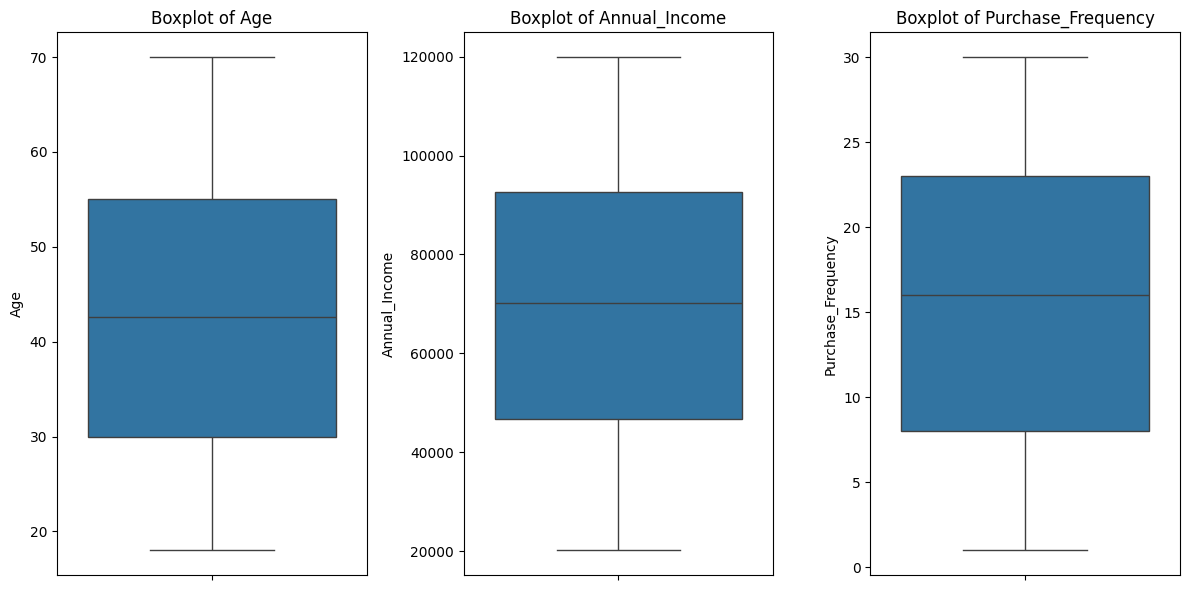

In [7]:
#Use the boxplot to check for outliers in the Age, Annual_Income, Purchase_Frequency
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 6))

numerical_cols = ['Age', 'Annual_Income', 'Purchase_Frequency']

# Create boxplots for each numerical column
for col in numerical_cols:
    plt.subplot(1, 3, numerical_cols.index(col) + 1)
    sns.boxplot(data[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()


**Justification:** No outliers are in those columns as per the box plot.

In [8]:
# # Remove outliers using the IQR method
# for col in numerical_cols:
#     Q1 = data[col].quantile(0.25)
#     Q3 = data[col].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

# # Verify the dataset shape after removing outliers
# print(f"Dataset shape after removing outliers: {data.shape}")

Data cleaning for **Customer Reviews** columns

In [9]:
#Remove white spaces (trailing and leading), special characters, and convert to lowercase

def clean_text_column(data, col):
    data[col] = data[col].str.strip()  # Remove leading and trailing spaces
    data[col] = data[col].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)  # Remove special characters
    data[col] = data[col].str.lower()  # Convert to lowercase
    return data

clean_text_column(data,'Customer_Reviews')

# Verify the cleaned text column
print("Cleaned Customer_Reviews:")
print(data['Customer_Reviews'].head())




Cleaned Customer_Reviews:
0                   amazing highly recommended 
1    decent quality but shipping took too long 
2       its okay not the best but does the job 
3     great product would definitely buy again 
4    decent quality but shipping took too long 
Name: Customer_Reviews, dtype: object


In [10]:
data.shape

(1000, 11)

<h4>Feature Engineering</h4>

Removing **Customer_ID,Name columns** as they don't contribute  anything to target varible(i.e Target_Variable).

In [11]:
data = data.drop(['Customer_ID', 'Name'], axis=1)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 1000 non-null   float64
 1   Annual_Income       1000 non-null   float64
 2   Education_Level     1000 non-null   object 
 3   Occupation          1000 non-null   object 
 4   City                1000 non-null   object 
 5   Customer_Reviews    1000 non-null   object 
 6   Purchase_Frequency  1000 non-null   int64  
 7   Product_Category    1000 non-null   object 
 8   Target_Variable     1000 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 70.4+ KB


In [13]:
data.shape

(1000, 9)

**Justification:** As for model buidling all the values must be in numerical values so for categorical column we need encode those values in the numerical representation.

- One hot encoding for unorded catgorical columns like **City, Occupation, Product_Category**

In [14]:
unordered_cols = ['Occupation', 'City', 'Product_Category']


#Use get_dummies to convert categorical variables into dummy/indicator variables 
data = pd.get_dummies(data, columns=unordered_cols, drop_first=True) 



# Verify the shape of the dataset after one-hot encoding
print(f"Dataset shape after one-hot encoding: {data.shape}")

Dataset shape after one-hot encoding: (1000, 19)


In [15]:
data.head()

,Age,Annual_Income,Education_Level,Customer_Reviews,Purchase_Frequency,Target_Variable,Occupation_Doctor,Occupation_Engineer,Occupation_Lawyer,Occupation_Scientist,Occupation_Teacher,City_Houston,City_Los Angeles,City_New York,City_Phoenix,Product_Category_Clothing,Product_Category_Electronics,Product_Category_Home Appliances,Product_Category_Toys
0,64.0,77964.61,Bachelor,amazing highly recommended,11,High,False,True,False,False,False,False,False,False,True,False,False,True,False
1,24.0,68414.99,High School,decent quality but shipping took too long,17,Low,False,False,False,False,False,False,False,False,False,False,False,False,False
2,66.0,93824.94,High School,its okay not the best but does the job,2,Low,False,True,False,False,False,False,True,False,False,False,False,False,True
3,31.0,39551.43,PhD,great product would definitely buy again,29,Low,False,True,False,False,False,True,False,False,False,False,False,True,False
4,19.0,41216.05,Bachelor,decent quality but shipping took too long,16,Medium,False,False,False,False,True,False,False,True,False,True,False,False,False


- Ordinal Encoding for ordered categorical column (**i.e Education Level**)

In [16]:
#Ordinal encoding for Education_Level
from sklearn.preprocessing import OrdinalEncoder

education_order = [['High School', 'Bachelor', 'Master', 'PhD']]
ord_enc = OrdinalEncoder(categories=education_order)
data['Education_Level'] = ord_enc.fit_transform(data[['Education_Level']])

# Verify the ordinal encoding
print("Ordinal encoding for Education_Level:")
print(data['Education_Level'].head())

Ordinal encoding for Education_Level:
0    1.0
1    0.0
2    0.0
3    3.0
4    1.0
Name: Education_Level, dtype: float64


In [17]:
data.head()

,Age,Annual_Income,Education_Level,Customer_Reviews,Purchase_Frequency,Target_Variable,Occupation_Doctor,Occupation_Engineer,Occupation_Lawyer,Occupation_Scientist,Occupation_Teacher,City_Houston,City_Los Angeles,City_New York,City_Phoenix,Product_Category_Clothing,Product_Category_Electronics,Product_Category_Home Appliances,Product_Category_Toys
0,64.0,77964.61,1.0,amazing highly recommended,11,High,False,True,False,False,False,False,False,False,True,False,False,True,False
1,24.0,68414.99,0.0,decent quality but shipping took too long,17,Low,False,False,False,False,False,False,False,False,False,False,False,False,False
2,66.0,93824.94,0.0,its okay not the best but does the job,2,Low,False,True,False,False,False,False,True,False,False,False,False,False,True
3,31.0,39551.43,3.0,great product would definitely buy again,29,Low,False,True,False,False,False,True,False,False,False,False,False,True,False
4,19.0,41216.05,1.0,decent quality but shipping took too long,16,Medium,False,False,False,False,True,False,False,True,False,True,False,False,False


- For textual data (i.e **Customer_Reviews**) is still in free text format so we need to encode it as well for this we will be using various  feature engineering techniques like TD-IDF.

In [18]:
#Import tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TfidfVectorizer object
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the Customer_Reviews column
tfidf_matrix = tfidf_vectorizer.fit_transform(data['Customer_Reviews'])

# Convert the tfidf_matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Concatenate the original data with the tfidf_df
data = pd.concat([data, tfidf_df], axis=1)

# Drop the original Customer_Reviews column
data.drop('Customer_Reviews', axis=1, inplace=True)

# Verify the shape of the dataset after TF-IDF transformation
print(f"Dataset shape after TF-IDF transformation: {data.shape}")

Dataset shape after TF-IDF transformation: (1000, 53)


In [19]:
tfidf_df.head()

,amazing,best,better,buy,customer,damaged,decent,definitely,disappointed,does,...,purchase,quality,recommended,review,service,shipping,shopping,terrible,took,worst
0,0.57735,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.57735,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
1,0.00000,0.0,0.0,0.000000,0.0,0.0,0.447214,0.000000,0.0,0.0,...,0.0,0.447214,0.00000,0.0,0.0,0.447214,0.0,0.0,0.447214,0.0
2,0.00000,0.5,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.5,...,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
3,0.00000,0.0,0.0,0.525585,0.0,0.0,0.000000,0.525585,0.0,0.0,...,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
4,0.00000,0.0,0.0,0.000000,0.0,0.0,0.447214,0.000000,0.0,0.0,...,0.0,0.447214,0.00000,0.0,0.0,0.447214,0.0,0.0,0.447214,0.0


In [20]:
data.head()

,Age,Annual_Income,Education_Level,Purchase_Frequency,Target_Variable,Occupation_Doctor,Occupation_Engineer,Occupation_Lawyer,Occupation_Scientist,Occupation_Teacher,...,purchase,quality,recommended,review,service,shipping,shopping,terrible,took,worst
0,64.0,77964.61,1.0,11,High,False,True,False,False,False,...,0.0,0.000000,0.57735,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
1,24.0,68414.99,0.0,17,Low,False,False,False,False,False,...,0.0,0.447214,0.00000,0.0,0.0,0.447214,0.0,0.0,0.447214,0.0
2,66.0,93824.94,0.0,2,Low,False,True,False,False,False,...,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
3,31.0,39551.43,3.0,29,Low,False,True,False,False,False,...,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
4,19.0,41216.05,1.0,16,Medium,False,False,False,False,True,...,0.0,0.447214,0.00000,0.0,0.0,0.447214,0.0,0.0,0.447214,0.0


- Map target classes to numerical values
 

In [21]:
target_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
data['Target_Variable'] = data['Target_Variable'].map(target_mapping)

# Verify the mapping
print("Target variable mapping:")
print(data['Target_Variable'].head())


Target variable mapping:
0    2
1    0
2    0
3    0
4    1
Name: Target_Variable, dtype: int64


- Scaling numerical columns **Age and Annual_income** using StandardScaler

In [22]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Scale the numerical columns Age and Annual_Income
numerical_cols = ['Age', 'Annual_Income']
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Verify the scaling
print("Scaled numerical columns:")
print(data[numerical_cols].head())

Scaled numerical columns:
        Age  Annual_Income
0  1.419282       0.281403
1 -1.228632      -0.060788
2  1.551678       0.849725
3 -0.765247      -1.095054
4 -1.559622      -1.035406


In [23]:
data.shape

(1000, 53)

As there are now **more than 53 features** we need to apply some dimension reduction techniques like **PCA so that the training time for model buidling reduces significantly.**

- Dimensionality reduction using PCA

In [24]:
from sklearn.decomposition import PCA

# Initialize PCA with 2 components
pca = PCA(n_components=2) 


pca_df = data.drop('Target_Variable', axis=1)

# Fit PCA on the data
features_reduced = pca.fit_transform(pca_df)

pca_df= pd.DataFrame()

pca_df['PCA1'] = features_reduced[:, 0]
pca_df['PCA2'] = features_reduced[:, 1]
pca_df.head()


,PCA1,PCA2
0,-4.346778,0.064113
1,1.639847,-1.808121
2,-13.357381,-0.814878
3,13.649790,1.069801
4,0.645327,-1.085712


In [25]:
pca_df.shape

(1000, 2)

<h5>Model Building</h5>